In [1]:
import kagglehub

path = kagglehub.dataset_download("lbquctrung/worksite-safety-monitoring-dataset")

print("Path to dataset files:", path)

100%|██████████| 98.9M/98.9M [00:06<00:00, 16.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lbquctrung/worksite-safety-monitoring-dataset/versions/1


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [3]:
train_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train'
test_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/test'
valid_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/valid'

In [4]:
train_safe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train/safe'
train_unsafe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train/unsafe'
test_safe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/test/safe'
test_unsafe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/test/unsafe'
valid_safe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/valid/safe'
valid_unsafe_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/valid/unsafe'

In [5]:
safe_images = os.listdir(train_safe_dir)
unsafe_images = os.listdir(train_unsafe_dir)

print("Jumlah Gambar Safe", len(safe_images))
print("Jumlah Gambar Unsafe", len(unsafe_images))

safe_images_valid = os.listdir(valid_safe_dir)
unsafe_images_valid = os.listdir(valid_unsafe_dir)

print("Jumlah Gambar Safe", len(safe_images_valid))
print("Jumlah Gambar Unsafe", len(unsafe_images_valid))

Jumlah Gambar Safe 810
Jumlah Gambar Unsafe 810
Jumlah Gambar Safe 100
Jumlah Gambar Unsafe 100


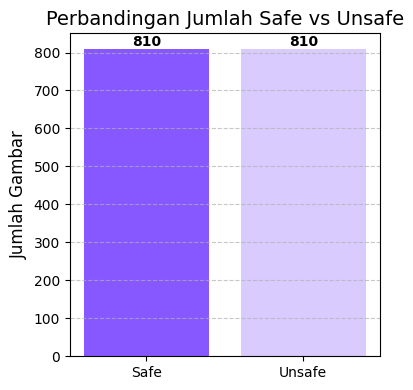

In [6]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Safe', 'Unsafe']
counts = [len(safe_images), len(unsafe_images)]
colors = ['#8758ff', '#dacbff']

plt.figure(figsize=(4, 4))
bars = plt.bar(categories, counts, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.title('Perbandingan Jumlah Safe vs Unsafe', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Gambar 623.jpg: Shape = (640, 640, 3)
Gambar 764.jpg: Shape = (640, 640, 3)


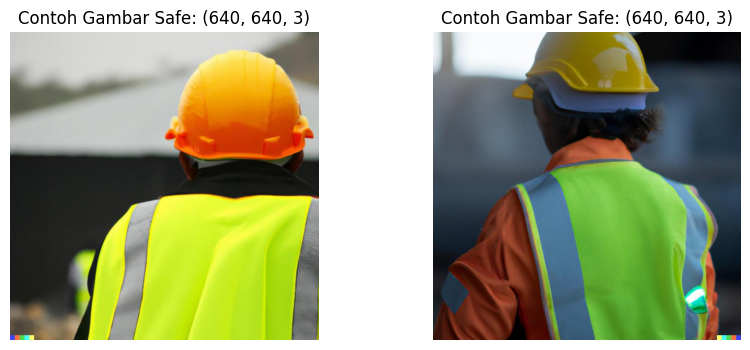

In [7]:
from PIL import Image

plt.figure(figsize=(10, 4))
for i, img_path in enumerate(safe_images[:2]):
    img = Image.open(os.path.join(train_safe_dir, img_path))
    plt.subplot(1, 2, i+1)
    img_array = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Contoh Gambar Safe: {img_array.shape}")
    print(f"Gambar {img_path}: Shape = {img_array.shape}")
plt.show()

Gambar 4.jpg: Shape = (640, 640, 3)
Gambar 5.jpg: Shape = (640, 640, 3)


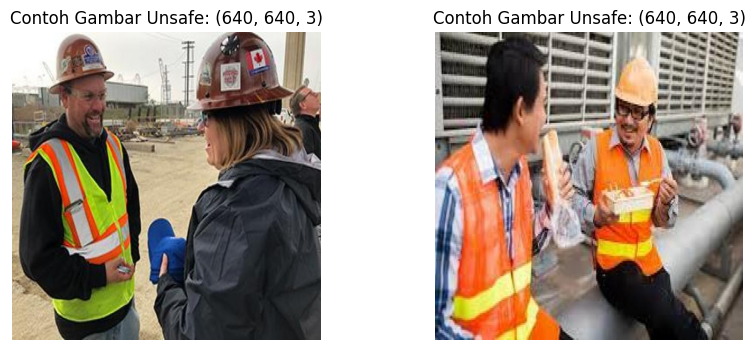

In [8]:
unsafe_images = sorted(
    os.listdir(train_unsafe_dir),
    key=lambda x: int(os.path.splitext(x)[0])
)

plt.figure(figsize=(10, 4))
for i, img_path in enumerate(unsafe_images[3:5]):
    img = Image.open(os.path.join(train_unsafe_dir, img_path))
    img_array = np.array(img)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Contoh Gambar Unsafe: {img_array.shape}")
    print(f"Gambar {img_path}: Shape = {img_array.shape}")
plt.show()

In [9]:

train_datagen_noscale = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_noscale = ImageDataGenerator()
valid_datagen_noscale = ImageDataGenerator()

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_resnet_model_128(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


train_datagen_noscale = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)  # tanpa rescale
valid_datagen_noscale = ImageDataGenerator()

train_generator = train_datagen_noscale.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
)

valid_generator = valid_datagen_noscale.flow_from_directory(
  valid_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',
  color_mode="rgb",
  shuffle=True
)

model = build_resnet_model_128()
opt = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("models/best_resnet_model.h5", save_best_only=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=15, callbacks=[early_stop, checkpoint])


Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5512 - loss: 0.9137

51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.5520 - loss: 0.9120 - val_accuracy: 0.6500 - val_loss: 0.6072
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6581 - loss: 0.7103

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.6584 - loss: 0.7096 - val_accuracy: 0.7100 - val_loss: 0.5390
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7088 - loss: 0.6435

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.7091 - loss: 0.6428 - val_accuracy: 0.7300 - val_loss: 0.5000
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7592 - loss: 0.5289

51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.7591 - loss: 0.5290 - val_accuracy: 0.7700 - val_loss: 0.4732
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7646 - loss: 0.5079

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.7648 - loss: 0.5076 - val_accuracy: 0.7850 - val_loss: 0.4391
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7810 - loss: 0.4945

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.7810 - loss: 0.4942 - val_accuracy: 0.7700 - val_loss: 0.4381
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7866 - loss: 0.4317

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.7868 - loss: 0.4317 - val_accuracy: 0.8100 - val_loss: 0.4285
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8197 - loss: 0.4125

51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.8196 - loss: 0.4127 - val_accuracy: 0.8000 - val_loss: 0.4080
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8089 - loss: 0.4126

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.8089 - loss: 0.4126 - val_accuracy: 0.7900 - val_loss: 0.4068
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8193 - loss: 0.3696

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.8194 - loss: 0.3697 - val_accuracy: 0.8100 - val_loss: 0.3953
Epoch 11/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.8259 - loss: 0.3798 - val_accuracy: 0.8150 - val_loss: 0.3970
Epoch 12/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8317 - loss: 0.3546

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8318 - loss: 0.3547 - val_accuracy: 0.8100 - val_loss: 0.3807
Epoch 13/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8736 - loss: 0.3178

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.8732 - loss: 0.3182 - val_accuracy: 0.8100 - val_loss: 0.3724
Epoch 14/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8618 - loss: 0.3136

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.8617 - loss: 0.3137 - val_accuracy: 0.8200 - val_loss: 0.3692
Epoch 15/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.8457 - loss: 0.3625 - val_accuracy: 0.8100 - val_loss: 0.3779


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,375,941 (92.99 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

 Optimizer params: 525,316 (2.00 MB)

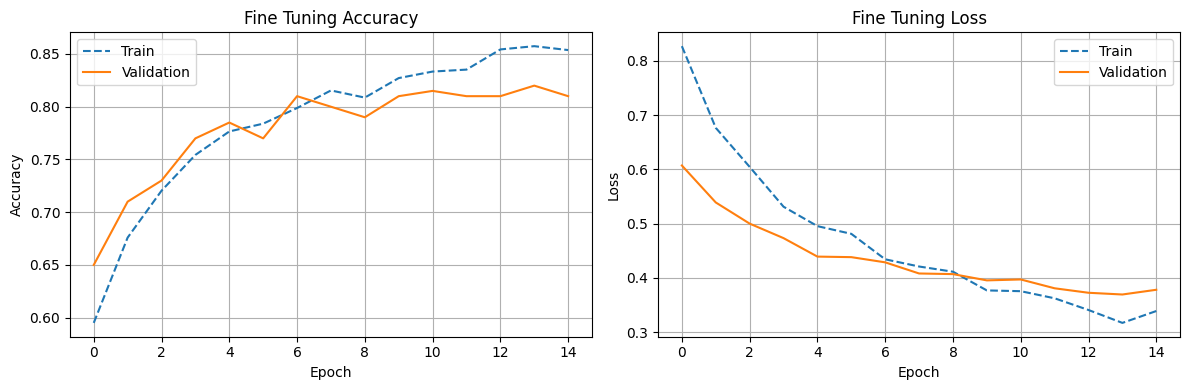

In [12]:
def plot_results_separated(hist):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"Fine Tuning Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_results_separated(hist=history)

In [13]:
model.evaluate(valid_generator) #Evaluasi performa model

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8188 - loss: 0.3652


[0.3692346513271332, 0.8199999928474426]

In [14]:
test_generator = test_datagen_noscale.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 200 images belonging to 2 classes.


In [15]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8914 - loss: 0.3298
Test Loss: 0.3883
Test Accuracy: 0.8550


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 753ms/step


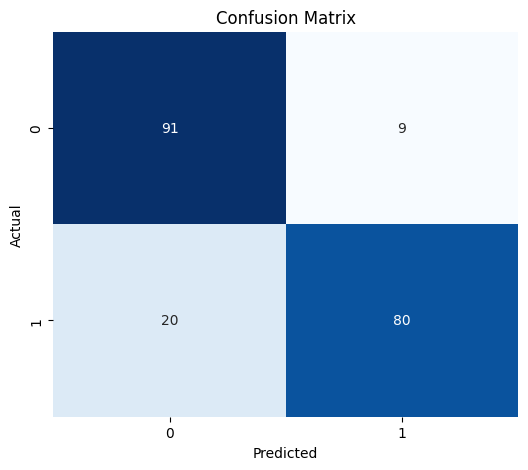

Accuracy Score: 0.855
Confusion Matrix:
[[91  9]
 [20 80]]
Classification Report:
              precision    recall  f1-score   support

        safe       0.82      0.91      0.86       100
      unsafe       0.90      0.80      0.85       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

test_generator.reset()

# Prediksi probabilitas dan ubah jadi label 0/1
pred_probs = model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Label sebenarnya
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_labels, pred_labels)

# Plot heatmap confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Evaluasi metrik
print("Accuracy Score:", accuracy_score(true_labels, pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))


In [17]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/model.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
base_model = model.get_layer("resnet50")
for layer in base_model.layers:
    if "conv5_block3" in layer.name:
        print(layer.name)

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


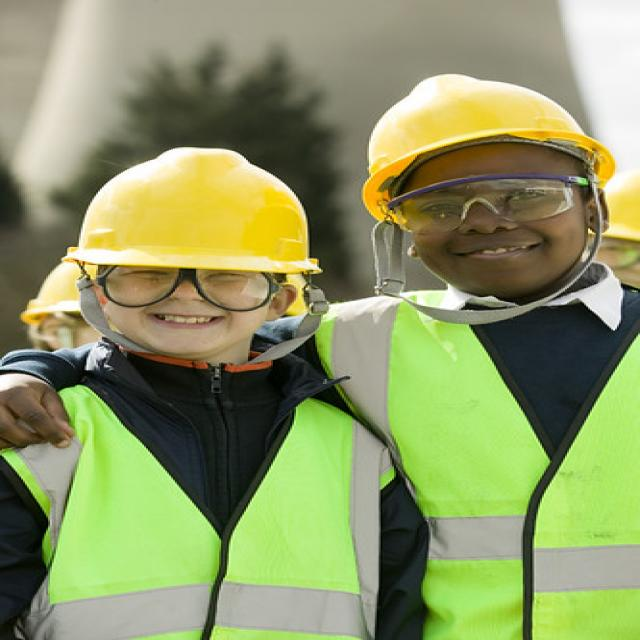

In [18]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

img_size = (224, 224)  # ukuran standar ResNet50
class_names = ['safe', 'unsafe']  # ubah sesuai label datasetmu
alpha = 0.4

# Path ke gambar
img_path = "/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train/safe/1.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = array / 255.0
    array = np.expand_dims(array, axis=0)
    return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     try:
#         # Coba akses layer conv terakhir dari ResNet50
#         base_model = None
#         for layer in model.layers:
#             if hasattr(layer, 'name') and 'resnet50' in layer.name.lower():
#                 base_model = layer
#                 break

#         if base_model is None:
#             # Jika tidak ditemukan, cari layer dengan nama yang mengandung 'conv'
#             conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]
#             if conv_layers:
#                 last_conv_layer_name = conv_layers[-1].name
#             else:
#                 raise ValueError("Tidak dapat menemukan convolutional layer")
#     except:
#         last_conv_layer_name = "conv5_block3_out"


#     grad_model = models.Model(
#         model.inputs, [model.get_layer('resnet50').get_layer(last_conv_layer_name).output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         conv_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])

#         # Untuk binary classification dengan sigmoid
#         class_channel = preds[:, 0]

#     grads = tape.gradient(class_channel, conv_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_output = conv_output[0]
#     heatmap = conv_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()



In [19]:
img_array = get_img_array(img_path, size=img_size)

preds = model.predict(img_array)
confidence = preds[0][0] if preds[0][0] > 0.5 else 1 - preds[0][0]

class_names = ["safe", "unsafe"]
predicted_class_index = np.argmax(preds)
predicted_class = class_names[predicted_class_index]
print(f"Prediksi: {predicted_class} (confidence: {confidence:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediksi: safe (confidence: 0.999)


In [21]:
save_name = '/kaggle/working/mymodelpath'
model.export(save_name)

Saved artifact at '/kaggle/working/mymodelpath'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134179615758608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134180204616528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180204618832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180204617872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180204616336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180204618064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180204618448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180053650896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180053652432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134180053653392: TensorSpec(shape=(), dtype=tf.resource, nam

In [ ]:
base_model = model.get_layer("resnet50")
for layer in base_model.layers:
    print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [ ]:
import matplotlib as mpl
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create image with RGB color
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    # Save the superimposed image
    Superimposed_img.save(cam_path)

    # Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

NameError: name 'heatmap' is not defined